# TODO: continue with;
## stop_ratio = 0.10         # stop when FFT peak < 10 % of first peak

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pymc as pm
import pytensor.tensor as pt

In [2]:
def build_model(t, A, P, phi):
    return A * np.cos(2 * np.pi * t / P + phi)

def generate_P_guess(t, y):
    dt  = np.median(np.diff(t))
    t_u = np.arange(t[0], t[-1]+dt, dt)
    y_u = np.interp(t_u, t, y)
    
    freq   = np.fft.fftfreq(len(t_u), dt)
    amp    = 2/len(t_u) * np.abs(np.fft.fft(y_u))
    pos    = freq > 0
    peaks, props = find_peaks(amp[pos], prominence=amp[pos].max()*0.05)
    
    P_guess = 1/freq[pos][peaks][0]

    if len(peaks) == 0:
        return None, None                        # no significant peak left

    peak_idx = peaks[np.argmax(props["prominences"])]
    return 1 / freq[pos][peak_idx], amp[pos][peak_idx]  # period, amplitude

def extract_harmonic(t, y, period_min=None, period_max=None, n_samples=1000, n_tune=1000, 
                       n_chains=2, target_accept=0.95, seed=None):
    
    if period_min is None or period_max is None:
        period_min, period_max = 2 * np.min(np.diff(t)), n_years
    #P_guess, peak_amp = generate_P_guess(t, y)
    #print(f"FFT dominant period ≈ {P_guess:,.0f} yr")

    with pm.Model() as harmonic:
        # priors
        A = pm.HalfNormal("A", sigma=2*np.std(y))
        #period = pm.Normal("P", mu=P_guess, sigma=0.25*P_guess)
        period = pm.Uniform("P", period_min, period_max)
        phase = pm.Uniform("phi", lower=0, upper=2*np.pi)
        sigma = pm.HalfNormal("sigma", sigma=np.std(y))

        # likelihood
        # mu  = A * pm.math.cos(2 * np.pi * t / period + phase)
        mu = pm.Deterministic("mu", A * pt.cos(2*np.pi * t / period + phase))

        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        trace = pm.sample(n_samples, tune=n_tune, chains=n_chains,
                          cores=min(4, n_chains),
                          target_accept=target_accept,
                          return_inferencedata=True,
                          random_seed=seed
                         )

    A_hat   = trace.posterior["A"].mean().item()
    P_hat   = trace.posterior["P"].mean().item()
    phi_hat = trace.posterior["phi"].mean().item()

    return (A_hat, P_hat, phi_hat), trace

def extract_harmonics(t, y, k=2, period_min=None, period_max=None, n_samples=1000, n_tune=1000, 
                       n_chains=2, target_accept=0.95, seed=None):
    if period_min is None or period_max is None:
        period_min, period_max = 2 * np.min(np.diff(t)), 2*t[-1]

    with pm.Model() as harmonic_k:
        A   = pm.HalfNormal("A", sigma=2*np.std(y), shape=k)
        P   = pm.Uniform("P", 1000, 30000, shape=k)
        phi = pm.Uniform("phi", 0, 2*np.pi, shape=k)
        σ   = pm.HalfNormal("σ", 0.2)
    
        μ = pm.Deterministic(
            "μ",
            (A * pt.cos(2*np.pi * t[:, None] / P + phi)).sum(axis=1)
        )
    
        y_obs = pm.Normal("y_obs", μ, σ, observed=y)
        trace = pm.sample(n_samples, tune=n_tune, chains=n_chains,
                          cores=min(4, n_chains),
                          target_accept=target_accept,
                          return_inferencedata=True,
                          random_seed=seed
                         )

    A_hat   = trace.posterior["A"].mean().item()
    P_hat   = trace.posterior["P"].mean().item()
    phi_hat = trace.posterior["phi"].mean().item()

    return (A_hat, P_hat, phi_hat), trace

In [135]:
n_years = 10000

df = pd.read_excel("./data/d18O NGRIP 21.04.24.xlsx", 
                   sheet_name="Raw Data", header=None, 
                   engine="openpyxl")

df_data = df.iloc[10:6124,2:4]
df_data.columns = ["Age", "d18o"]

# set first year to 0 and choose years less than "n_years"
df_data["Age"] -= min(df_data["Age"])
df_data = df_data[df_data["Age"] <= n_years]
# center data
df_data["d18o"] -= np.mean(df_data["d18o"]) 

t = df_data["Age"].values.astype("float")
y = df_data["d18o"].values.astype("float")

#plt.plot(t, y,  lw=0.2, c="k", label="Original Data");

In [125]:
method = 1
n_harmonics = 3
residuals = y.copy()

if method == 1:
    harmonics = []
    for i in range(n_harmonics):
        print(f"***** Iteration number {i+1} of {n_harmonics} ({int(100*i/max(n_harmonics-1, 1))} %) *******")
        (A, P, phi), trace = extract_harmonic(t, residuals, n_samples=4000, n_tune=2000, n_chains=4)
        harmonic = build_model(t, A, P, phi)
        
        harmonics.append(harmonic)
        residuals = residuals - harmonic
    
    total_model = np.sum(harmonics, axis=0)
else:
    (A, P, phi), trace = extract_harmonics(t, residuals, k=n_harmonics, n_samples=4000, n_tune=2000, n_chains=4)
    harmonic = build_model(t, A, P, phi)
    total_model = harmonic

# target model for comparison
target_P = [36231, 15340, 13332]
target_A = [4.45, 1.57, 0.92]
target_phi = [5.33, 4.23, 0.79]
target_model = sum([target_A[i] * np.cos(2 * np.pi * t / target_P[i] + target_phi[i]) 
     for i in range(n_harmonics)])

***** Iteration number 1 of 3 (0 %) *******


NameError: name 'extract_harmonic' is not defined

NameError: name 'total_model' is not defined

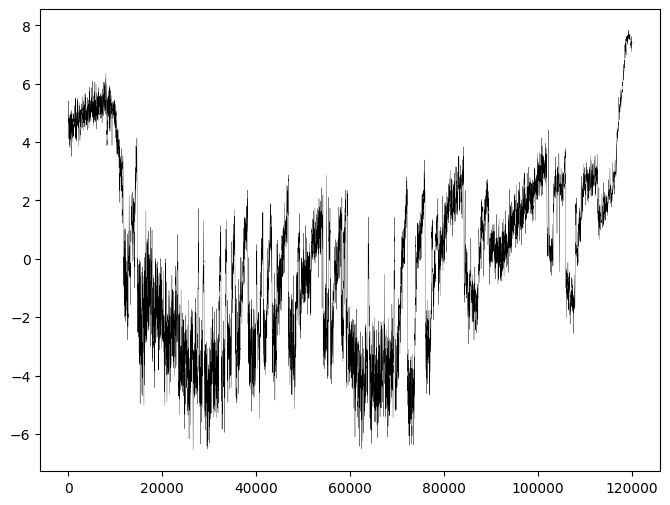

In [126]:
plt.figure(figsize=(8, 6))
plt.plot(t, y,  lw=0.2, c="k", label="Original Data")
plt.plot(t, total_model, "--", label="Bayesian Fit")
plt.plot(t, target_model, "-.", label="Target Fit")
# plt.plot(t, residuals, lw=0.4, label="Residuals")
plt.legend()
plt.title("Bayesian Harmonic Fit")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.grid(True)
plt.show()

#plt.figure(figsize=(7,7))
#pm.plot_trace(trace)
#plt.tight_layout()

# fourier

In [136]:
dt  = np.median(np.diff(t))
t_u = np.arange(t[0], t[-1]+dt, dt)
y_u = np.interp(t_u, t, y)

Found 23 peaks.
Periods: [251.          25.1         12.55        10.91304348   8.96428571
   8.09677419   7.60606061   6.78378378   5.22916667   4.73584906
   4.32758621   3.8030303    3.09876543   2.69892473   2.61458333
   1.91603053   1.73103448   1.65131579   1.41011236   1.33510638
   1.255        1.1728972    1.13063063]


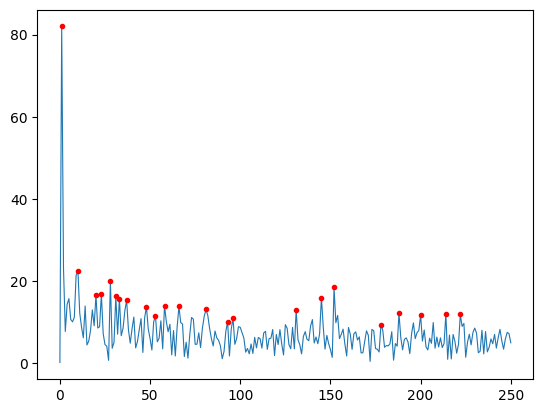

In [147]:
ck = np.fft.rfft(y_u)
abs_ck = abs(ck) 
peaks = find_peaks(abs_ck, prominence=max(abs_ck)*0.095)[0]
print(f"Found {len(peaks)} peaks.")

plt.plot(abs_ck, lw=0.8)
plt.plot(peaks, abs_ck[peaks], ".r");

periods = len(ck) / peaks
print(f"Periods: {periods}")

ck[list(set(range(len(abs_ck)))-set(peaks))] = 0
new_y = np.fft.irfft(ck)

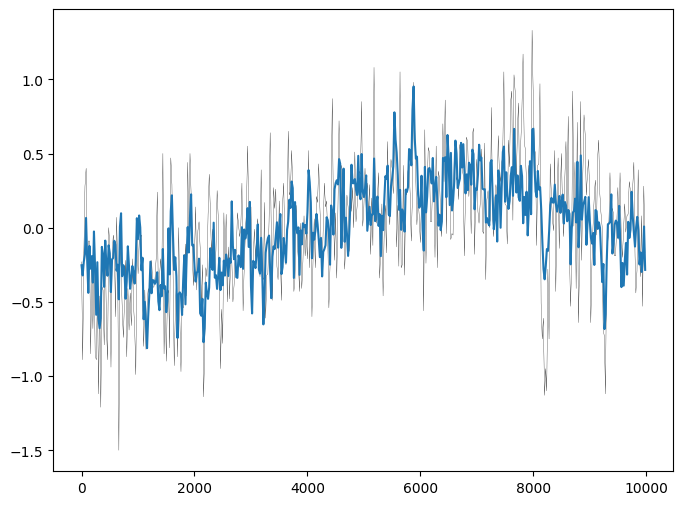

In [148]:
plt.figure(figsize=(8, 6))
plt.plot(t, y,  lw=0.2, c="k", label="Original Data")
plt.plot(t_u, new_y)

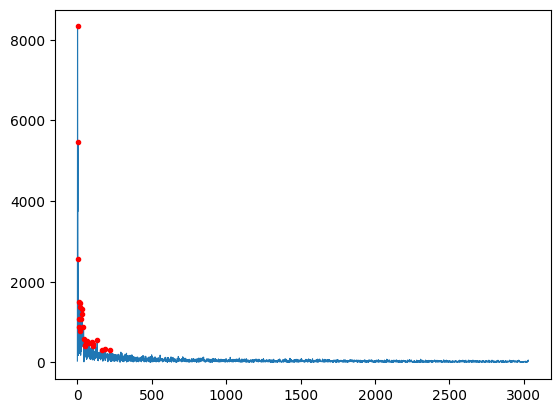

FFT dominant period ≈ 40,003 yr


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, c0, sigma]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 26 seconds.


            mean       sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
A         -1.874    0.048     -1.965     -1.787      0.000    0.000   19964.0   
P      37766.314  157.089  37478.786  38067.278      1.464    1.035   11510.0   
phi        1.942    0.037      1.874      2.011      0.000    0.000   11515.0   
c0        -0.054    0.034     -0.117      0.012      0.000    0.000   17670.0   
sigma      2.655    0.024      2.610      2.699      0.000    0.000   18902.0   

       ess_tail  r_hat  
A       12297.0    1.0  
P       10920.0    1.0  
phi     10936.0    1.0  
c0      10891.0    1.0  
sigma   11934.0    1.0  


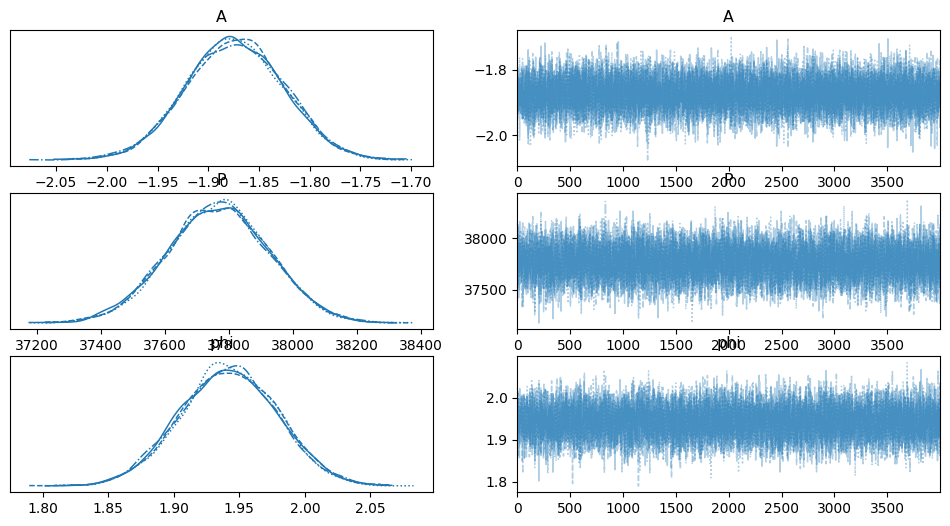

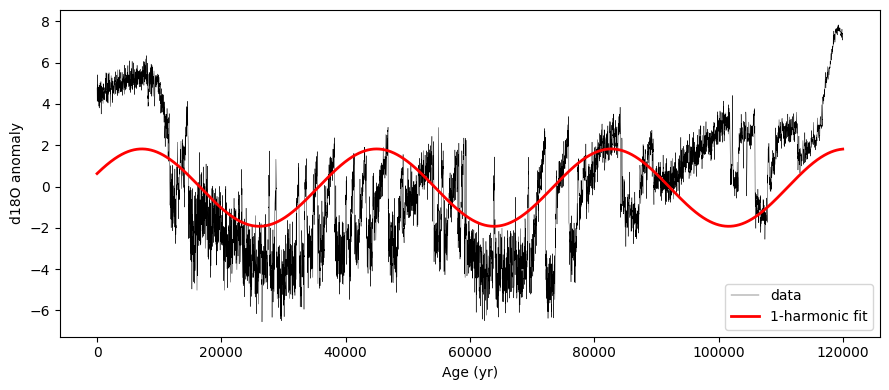

In [8]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ------------------------------------------------------------
# 1) Load & centre data
# ------------------------------------------------------------
df = (pd.read_excel("./data/d18O NGRIP 21.04.24.xlsx",
                    sheet_name="Raw Data",
                    header=None,
                    engine="openpyxl")
        .iloc[10:6124, 2:4]
        .rename(columns={2: "Age", 3: "d18O"}))

df["Age"]  -= df["Age"].min()             # start at 0
df["d18O"] -= df["d18O"].mean()           # zero-mean

t_raw = df["Age"].values.astype(float)    # 0 … ~120 000 yr
y     = df["d18O"].values.astype(float)
y_std = y.std()

# ------------------------------------------------------------
# 2) Quick FFT to get a period guess (top spectral peak)
# ------------------------------------------------------------
dt  = np.median(np.diff(t_raw))
t_u = np.arange(t_raw[0], t_raw[-1]+dt, dt)
y_u = np.interp(t_u, t_raw, y)

freq   = np.fft.fftfreq(len(t_u), dt)
amp    = 2/len(t_u) * np.abs(np.fft.fft(y_u))
pos    = freq > 0
peaks, _ = find_peaks(amp[pos], prominence=amp[pos].max()*0.05)
P_guess = 1/freq[pos][peaks][0]           # dominant period (yrs)

print(f"FFT dominant period ≈ {P_guess:,.0f} yr")

# ------------------------------------------------------------
# 3) Re-scale time to 0–1 (for sampler stability)
# ------------------------------------------------------------
t = (t_raw - t_raw.min()) / (t_raw.max() - t_raw.min())  # 0…1
T_span = t_raw.max() - t_raw.min()                       # so that  P = P_hat/T_span  inside the model

# ------------------------------------------------------------
# 4) PyMC model
# ------------------------------------------------------------
with pm.Model() as one_harmonic:
    # loose, data-informed priors
    A     = pm.Normal("A",   mu=0,           sigma=2*y_std)
    P     = pm.Normal("P",   mu=P_guess,     sigma=P_guess*0.25)  # ±25 %
    phi   = pm.Uniform("phi", lower=0, upper=2*np.pi)
    offset= pm.Normal("c0",  mu=0,           sigma=y_std)
    sigma = pm.HalfNormal("sigma", sigma=y_std)

    # deterministic mean (remember to undo the time rescale)
    mu = offset + A * pm.math.cos(2*np.pi * t_raw / P + phi)

    # likelihood
    pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    trace = pm.sample(draws=4000, tune=2000,
                      chains=4, target_accept=0.93,
                      return_inferencedata=True)

# ------------------------------------------------------------
# 5) Quick diagnostics
# ------------------------------------------------------------
print(az.summary(trace, var_names=["A","P","phi","c0","sigma"]))
az.plot_trace(trace, var_names=["A","P","phi"])
plt.show()

# Posterior mean curve
A_hat   = trace.posterior["A"].mean().item()
P_hat   = trace.posterior["P"].mean().item()
phi_hat = trace.posterior["phi"].mean().item()
c0_hat  = trace.posterior["c0"].mean().item()

model_curve = c0_hat + A_hat*np.cos(2*np.pi*t_raw/P_hat + phi_hat)

plt.figure(figsize=(9,4))
plt.plot(t_raw, y, lw=0.3, label="data", color="k")
plt.plot(t_raw, model_curve, "r", lw=2, label="1-harmonic fit")
plt.legend(); plt.xlabel("Age (yr)"); plt.ylabel("d18O anomaly")
plt.tight_layout(); plt.show()


► Harmonic 1: P≈24,002 yr  (FFT amp 0.85)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, c0, sigma]
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 26 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


► Harmonic 2: P≈24,002 yr  (FFT amp 0.77)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, c0, sigma]
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 28 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


► Harmonic 3: P≈40,003 yr  (FFT amp 1.75)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, c0, sigma]
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 26 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


► Harmonic 4: P≈9,231 yr  (FFT amp 0.47)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, c0, sigma]
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 32 seconds.


► Harmonic 5: P≈7,500 yr  (FFT amp 0.50)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, c0, sigma]
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 33 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


► Harmonic 6: P≈7,500 yr  (FFT amp 0.51)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, c0, sigma]
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 35 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


► Harmonic 7: P≈7,500 yr  (FFT amp 0.47)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, c0, sigma]
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 72 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


► Harmonic 8: P≈7,500 yr  (FFT amp 0.47)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, c0, sigma]
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 73 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


► Harmonic 9: P≈7,500 yr  (FFT amp 0.47)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, c0, sigma]
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 72 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


► Harmonic 10: P≈4,286 yr  (FFT amp 0.42)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, c0, sigma]
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 33 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


► Harmonic 11: P≈3,637 yr  (FFT amp 0.38)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, c0, sigma]
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 66 seconds.


► Harmonic 12: P≈6,000 yr  (FFT amp 0.41)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, c0, sigma]
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 37 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


► Harmonic 13: P≈6,000 yr  (FFT amp 0.36)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, c0, sigma]
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 71 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


► Harmonic 14: P≈4,286 yr  (FFT amp 0.36)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, c0, sigma]
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 54 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


► Harmonic 15: P≈7,500 yr  (FFT amp 0.34)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, c0, sigma]
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 36 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



Extracted 15 harmonics.


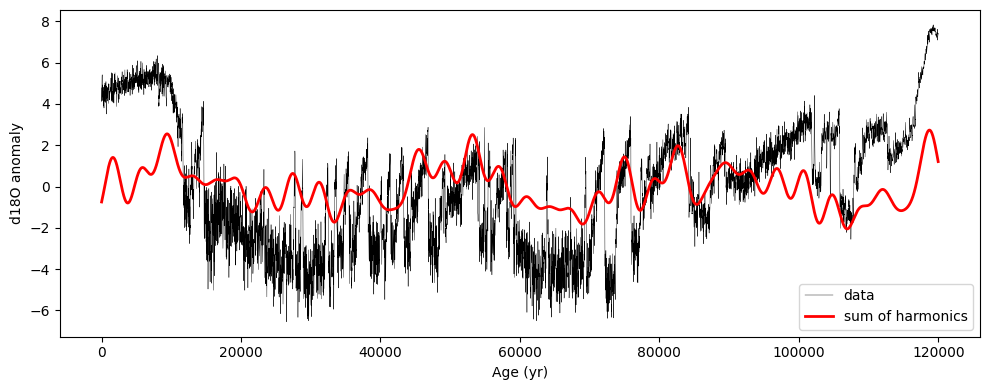

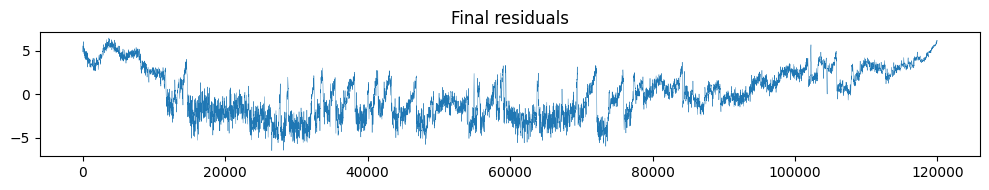

 1:  P =  22628.9 yr   A = -0.566   φ = 1.91 rad
 2:  P =  22964.9 yr   A = +0.422   φ = 3.17 rad
 3:  P =  37466.1 yr   A = +0.925   φ = 4.24 rad
 4:  P =   9066.3 yr   A = -0.502   φ = 2.75 rad
 5:  P =   7387.8 yr   A = -0.016   φ = 1.22 rad
 6:  P =   7372.2 yr   A = -0.302   φ = 1.85 rad
 7:  P =   7518.2 yr   A = -0.000   φ = 3.05 rad
 8:  P =   7518.1 yr   A = +0.000   φ = 3.05 rad
 9:  P =   7517.9 yr   A = +0.221   φ = 2.27 rad
10:  P =   4330.4 yr   A = +0.283   φ = 4.66 rad
11:  P =   3669.9 yr   A = +0.391   φ = 3.28 rad
12:  P =   6093.2 yr   A = +0.246   φ = 4.12 rad
13:  P =   5956.3 yr   A = -0.188   φ = 3.29 rad
14:  P =   4310.5 yr   A = +0.182   φ = 3.66 rad
15:  P =   7370.1 yr   A = -0.196   φ = 1.93 rad


In [6]:
# ------------------------------------------------------------
# 0) Libraries
# ------------------------------------------------------------
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Helper:  dominant period from an FFT ---------------------
# ------------------------------------------------------------
def dominant_period(t_raw, signal, prom_frac=0.05):
    """Return dominant period [years] from 1-D signal via FFT."""
    dt   = np.median(np.diff(t_raw))
    t_u  = np.arange(t_raw[0], t_raw[-1]+dt, dt)
    y_u  = np.interp(t_u, t_raw, signal)

    freq = np.fft.fftfreq(len(t_u), dt)
    amp  = 2/len(t_u) * np.abs(np.fft.fft(y_u))
    pos  = freq > 0

    peaks, props = find_peaks(amp[pos],
                              prominence=amp[pos].max()*prom_frac)
    if len(peaks) == 0:
        return None, None                        # no significant peak left

    peak_idx = peaks[np.argmax(props["prominences"])]
    return 1 / freq[pos][peak_idx], amp[pos][peak_idx]  # period, amplitude

# ------------------------------------------------------------
# 2) Helper:  fit a single cosine with PyMC ------------------
# ------------------------------------------------------------
def fit_one_harmonic(t_raw, y, P_guess, draws=4000, tune=2000, seed=None):
    """Return posterior means  A, P, φ,  plus the trace object."""
    y_std  = y.std()
    T_span = t_raw.max() - t_raw.min()
    t      = (t_raw - t_raw.min()) / T_span      # rescale 0…1

    with pm.Model() as mdl:
        A   = pm.Normal("A", mu=0,           sigma=2*y_std)
        P   = pm.Normal("P", mu=P_guess,     sigma=P_guess*0.25)
        phi = pm.Uniform("phi", lower=0,     upper=2*np.pi)
        c0  = pm.Normal("c0", mu=0,          sigma=y_std)
        sig = pm.HalfNormal("sigma", sigma=y_std)

        mu  = c0 + A * pm.math.cos(2*np.pi*(t*T_span)/P + phi)
        pm.Normal("y_obs", mu=mu, sigma=sig, observed=y)

        trace = pm.sample(draws=draws, tune=tune,
                          chains=4, target_accept=0.93,
                          progressbar=False,
                          random_seed=seed,
                          return_inferencedata=True)

    A_hat, P_hat, phi_hat, c0_hat = [
        trace.posterior[x].mean().item() for x in ("A", "P", "phi", "c0")
    ]
    curve = c0_hat + A_hat*np.cos(2*np.pi*t_raw/P_hat + phi_hat)
    return (A_hat, P_hat, phi_hat, c0_hat, curve, trace)

# ------------------------------------------------------------
# 3) Load & centre the data ----------------------------------
# ------------------------------------------------------------
RAW = "./data/d18O NGRIP 21.04.24.xlsx"
df  = (pd.read_excel(RAW, sheet_name="Raw Data", header=None,
                     engine="openpyxl")
         .iloc[10:6124, 2:4]
         .rename(columns={2: "Age", 3: "d18O"}))

df["Age"]  -= df["Age"].min()
df["d18O"] -= df["d18O"].mean()

t_raw = df["Age"].values.astype(float)
y_raw = df["d18O"].values.astype(float)

# ------------------------------------------------------------
# 4) Automatic harmonic extraction loop ----------------------
# ------------------------------------------------------------
max_harm   = 15           # safety cap
stop_ratio = 0.10         # stop when FFT peak < 10 % of first peak

residuals  = y_raw.copy()
models     = []           # store each harmonic curve
params     = []           # (A, P, φ)
peak0_amp  = None

for h in range(max_harm):
    P_guess, peak_amp = dominant_period(t_raw, residuals)

    if P_guess is None:           # no peak at all
        print("No further peaks — stop.")
        break
    if peak0_amp is None:         # remember amplitude of first peak
        peak0_amp = peak_amp
    elif peak_amp < peak0_amp*stop_ratio:
        print(f"Stopping: peak amplitude dropped below "
              f"{stop_ratio*100:.0f} % of first peak.")
        break

    print(f"► Harmonic {h+1}: P≈{P_guess:,.0f} yr  (FFT amp {peak_amp:.2f})")

    A,P,phi,c0,curve,trace = fit_one_harmonic(t_raw, residuals, P_guess,
                                              seed=1+h)
    params.append((A,P,phi,c0))
    models.append(curve)
    residuals -= curve

print(f"\nExtracted {len(models)} harmonics.")

# ------------------------------------------------------------
# 5) Plot results --------------------------------------------
# ------------------------------------------------------------
total_model = np.sum(models, axis=0)

plt.figure(figsize=(10,4))
plt.plot(t_raw, y_raw, lw=0.3, label="data", color="k")
plt.plot(t_raw, total_model, "r", lw=2, label="sum of harmonics")
plt.legend(); plt.xlabel("Age (yr)"); plt.ylabel("d18O anomaly")
plt.tight_layout(); plt.show()

# optional: look at final residuals
plt.figure(figsize=(10,2))
plt.plot(t_raw, residuals, lw=0.3)
plt.title("Final residuals")
plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 6) Quick parameter table -----------------------------------
# ------------------------------------------------------------
for i,(A,P,phi,_) in enumerate(params,1):
    print(f"{i:2d}:  P = {P:8.1f} yr   "
          f"A = {A:+6.3f}   φ = {phi:4.2f} rad")
